# Prologue

## imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

pd.set_option('display.max_columns',100)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA


## definitions

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## Step 1: load the data

In [3]:
path = 'data\\NHANES_Diet_Diabetes_Risk.xls.csv'
df = pd.read_csv(path)
df.head(125)

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,...,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
0,73557,16888.32786,12930.89065,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.0,70.0,110.0,60.0,304.0,278.0,1398.0,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,73558,17932.14387,12684.14887,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.0,1477.0,1488.0,0.0,145.0,12.0,0.0,...,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2
2,73559,59641.81293,39394.23671,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.0,616.0,655.0,21.0,449.0,35.0,515.0,...,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,73561,59052.35703,39004.89299,1,63.0,2.0,2.0,18.0,1.0,1.0,1.0,13.0,4.0,NaN,4.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0,7.0,1421.0,55.24,178.20,87.78,12.3,55.36,4.479,26.216,1.263,41.0,53.17,0.0,738.0,863.0,0.0,1476.0,0.0,0.0,...,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,0
4,73562,49890.82866,0.00000,1,49.0,2.0,1.0,11.0,3.0,1.0,1.0,13.0,1.0,3.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,1785.0,55.11,189.59,81.75,22.6,93.92,22.155,40.013,23.550,534.0,12.30,0.0,272.0,355.0,172.0,776.0,300.0,2339.0,...,2.0,NaN,2.0,NaN,2.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,73741,34262.95523,30795.77456,1,25.0,2.0,2.0,32.0,4.0,2.0,1.0,13.0,1.0,3.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,1606.0,57.65,168.95,75.34,17.3,83.62,23.404,28.162,26.439,312.0,12.45,0.0,183.0,879.0,1115.0,7754.0,73.0,3052.0,...,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,1.0,2.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2


# Main

### Step 2: Data Preprocessing

In [4]:
df = df.set_index('SEQN')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6643 entries, 73557 to 83729
Columns: 168 entries, WTDRD1 to Diabetes_Risk
dtypes: float64(166), int64(2)
memory usage: 8.6 MB


#### train/test split

In [6]:
X = df.drop('Diabetes_Risk', axis=1)
y = df['Diabetes_Risk']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,...,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
SEQN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
78727,70710.30601,46705.128430,1,59.0,2.0,2.0,1.0,7.0,1.0,1.0,13.0,4.0,NaN,3.0,2.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,1339.0,50.73,211.40,77.68,15.8,34.75,11.780,10.515,8.776,63.0,2.54,0.0,246.0,294.0,164.0,509.0,7.0,303.0,827.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,1.0,5.0,2.0,NaN,2.0,NaN,1.0,2.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0
82233,60907.62017,88806.191190,1,25.0,2.0,2.0,0.0,5.0,1.0,1.0,13.0,3.0,3.0,1.0,1.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,858.0,45.09,105.41,16.39,5.7,27.83,9.012,9.554,6.515,253.0,1.96,0.0,226.0,233.0,0.0,97.0,5.0,448.0,424.0,...,4.0,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,1.0,3.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,4.0,2.0,NaN,2.0
74032,46703.93997,173276.611500,1,2.0,2.0,2.0,3.0,1.0,1.0,1.0,13.0,4.0,NaN,3.0,2.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,1356.0,59.90,167.90,115.17,5.2,50.45,23.208,15.741,4.577,166.0,1.83,0.0,249.0,266.0,39.0,181.0,16.0,1809.0,83.0,...,1.0,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79069,10390.35346,8097.175852,1,2.0,2.0,2.0,11.0,7.0,1.0,1.0,13.0,4.0,NaN,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,1797.0,98.61,204.13,62.15,25.1,71.02,13.122,24.368,25.394,243.0,10.95,0.0,456.0,532.0,265.0,751.0,67.0,4285.0,927.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77717,48746.26378,180853.851200,1,25.0,2.0,2.0,20.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,4299.0,138.95,559.97,299.94,27.8,174.33,65.027,59.996,27.510,276.0,15.81,0.0,606.0,737.0,18.0,1509.0,21.0,31209.0,928.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### impute and scale

In [8]:
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
pl = make_pipeline(impute_median, scaler)

num_tuple = ('numeric', pl, num_cols)

num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 ['WTDRD1',
  'WTDR2D',
  'DR1DRSTZ',
  'DR1EXMER',
  'DRABF',
  'DRDINT',
  'DR1DBIH',
  'DR1DAY',
  'DR1LANG',
  'DR1MNRSP',
  'DR1HELPD',
  'DBQ095Z',
  'DBD100',
  'DRQSPREP',
  'DR1STY',
  'DR1SKY',
  'DRQSDIET',
  'DRQSDT1',
  'DRQSDT2',
  'DRQSDT3',
  'DRQSDT4',
  'DRQSDT5',
  'DRQSDT6',
  'DRQSDT7',
  'DRQSDT8',
  'DRQSDT9',
  'DRQSDT10',
  'DRQSDT11',
  'DRQSDT12',
  'DRQSDT91',
  'DR1TNUMF',
  'DR1TKCAL',
  'DR1TPROT',
  'DR1TCARB',
  'DR1TSUGR',
  'DR1TFIBE',
  'DR1TTFAT',
  'DR1TSFAT',
  'DR1TMFAT',
  'DR1TPFAT',
  'DR1TCHOL',
  'DR1TATOC',
  'DR1TATOA',
  'DR1TRET',
  'DR1TVARA',
  'DR1TACAR',
  'DR1TBCAR',
  'DR1TCRYP',
  'DR1TLYCO',
  'DR1TLZ',
  'DR1TVB1',
  'DR1TVB2',
  'DR1TNIAC',
  'DR1TVB6',
  'DR1TFOLA',
  'DR1TFA',
  'DR1TFF',
  'DR1TFDFE',
  'DR1TCHL',
  'DR1TVB12',
  'DR1TB12A',
  'DR1TVC',
  'DR1TVD',
  'DR1TVK',
  'DR1TCALC

#### transform

In [9]:
transformer = ColumnTransformer([num_tuple], verbose_feature_names_out=False)

In [10]:
transformer.fit(X_train)

X_train_tf = transformer.transform(X_train)
X_test_tf = transformer.transform(X_test)
X_train_tf

array([[ 0.82824554,  0.12166907, -0.295989  , ...,  0.20397472,
        -0.03076465,  0.        ],
       [ 0.57917515,  0.89004663, -0.295989  , ...,  0.20397472,
        -0.03076465,  0.        ],
       [ 0.21828261,  2.43169835, -0.295989  , ...,  0.20397472,
        -0.03076465,  0.        ],
       ...,
       [ 1.05975259,  4.83394823, -0.295989  , ...,  0.20397472,
        -0.03076465,  0.        ],
       [-0.25529271, -0.36842503, -0.295989  , ...,  0.20397472,
        -0.03076465,  0.        ],
       [-0.52182212, -0.4799338 , -0.295989  , ...,  0.20397472,
        -0.03076465,  0.        ]])

### Step 3: Model - No PCA

#### KNN

In [11]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier()

In [12]:
knn.n_features_in_

166

#### Record time it takes to make prediction

In [13]:
%%time
preds = knn.predict(X_test_tf)

CPU times: total: 1.08 s
Wall time: 363 ms


CPU times: total: 1.19 s
Wall time: 375 ms

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      4085
           1       0.49      0.04      0.08       437
           2       0.68      0.04      0.08       460

    accuracy                           0.82      4982
   macro avg       0.66      0.36      0.35      4982
weighted avg       0.78      0.82      0.75      4982



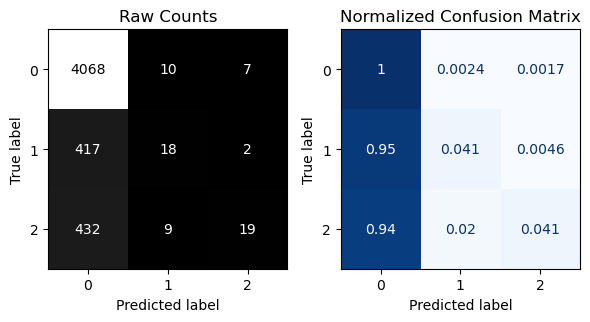


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1367
           1       0.25      0.03      0.05       150
           2       0.27      0.02      0.04       144

    accuracy                           0.82      1661
   macro avg       0.45      0.35      0.33      1661
weighted avg       0.73      0.82      0.75      1661



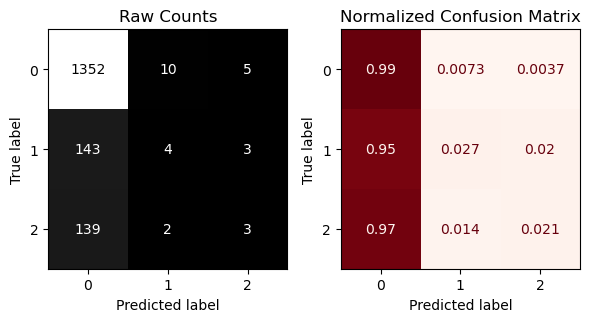

CPU times: total: 2.73 s
Wall time: 1.83 s


In [14]:
%%time
evaluate_classification(knn, X_train_tf, y_train, X_test_tf, y_test, cmap_train='Blues', cmap_test='Reds');

----------------------------------------------------------------------
 Classification Metrics: PCA KNN
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1367
           1       0.25      0.03      0.05       150
           2       0.27      0.02      0.04       144

    accuracy                           0.82      1661
   macro avg       0.45      0.35      0.33      1661
weighted avg       0.73      0.82      0.75      1661



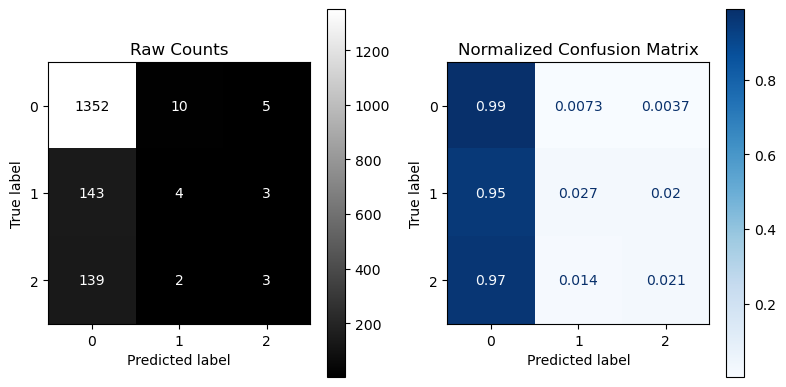

In [16]:
classification_metrics(y_test, preds, label="PCA KNN", normalize='true', cmap='Blues', colorbar=True);

## Step 4: Transform with PCA


In [ ]:
%%time

pca = PCA(n_components=0.95)
knn_pca_pipe = make_pipeline(SimpleImputer(strategy='median'), scaler, pca, knn)
knn_pca_pipe.fit(X_train, y_train)


CPU times: total: 62.5 ms
Wall time: 217 ms


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
knn_pca_pipe.named_steps['pca'].n_components_

99

## Step 5: PCA Model

In [ ]:
%%time

preds_pca = knn_pca_pipe.predict(X_test)

CPU times: total: 1.11 s
Wall time: 255 ms


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      4085
           1       0.50      0.05      0.09       437
           2       0.68      0.04      0.08       460

    accuracy                           0.82      4982
   macro avg       0.67      0.36      0.36      4982
weighted avg       0.79      0.82      0.76      4982



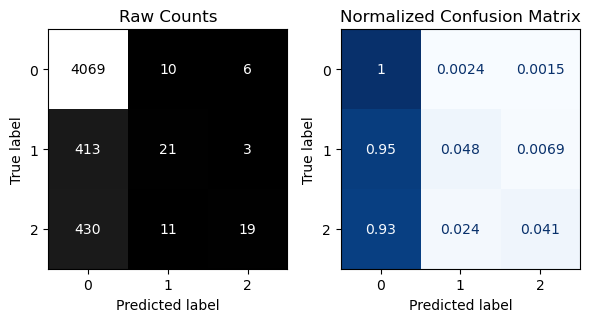


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1367
           1       0.19      0.02      0.04       150
           2       0.20      0.01      0.03       144

    accuracy                           0.82      1661
   macro avg       0.40      0.34      0.32      1661
weighted avg       0.71      0.82      0.75      1661



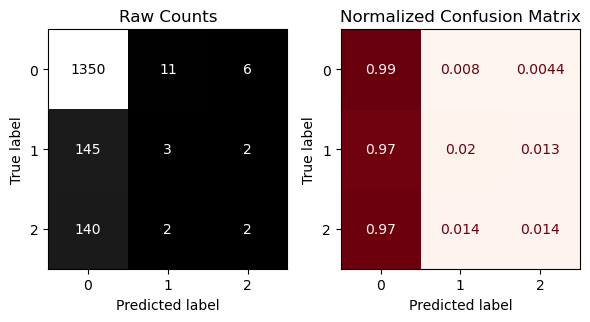

CPU times: total: 2.98 s
Wall time: 1.61 s


In [ ]:
%%time
evaluate_classification(knn_pca_pipe, X_train, y_train, X_test, y_test, cmap_train='Blues', cmap_test='Reds');

----------------------------------------------------------------------
 Classification Metrics: PCA KNN
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1367
           1       0.19      0.02      0.04       150
           2       0.20      0.01      0.03       144

    accuracy                           0.82      1661
   macro avg       0.40      0.34      0.32      1661
weighted avg       0.71      0.82      0.75      1661



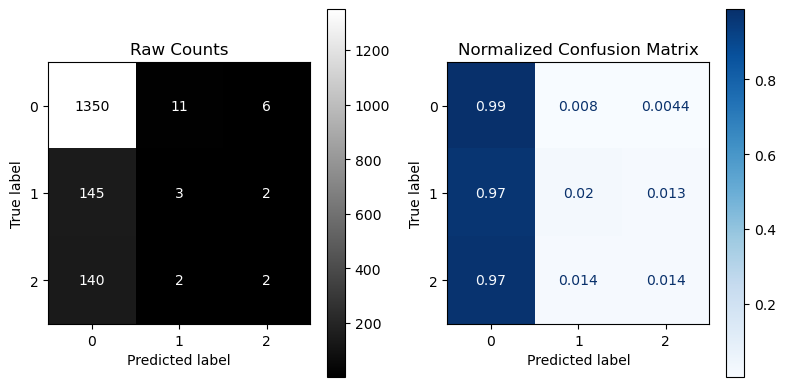

In [ ]:
classification_metrics(y_test, preds_pca, label="PCA KNN", normalize='true', cmap='Blues', colorbar=True)

## Step 6: Compare models

​In a markdown cell at the end of your notebook, answer the following questions:

Q1. How many features were used in the first model, and how many PCs were used in the PCA model?
  * 166 in the first, 99 in the PCA
  
Q2. Which model performed the best on the test set?
* They performed about the same

Q3. Which model was the fastest at making predictions?
  * The PCA model was faster

In [ ]:
# trim whitespace from markdown cells

# import nbformat as nbf

# def trim_whitespace_in_notebook(notebook_path):
#     # Read the notebook
#     with open(notebook_path) as f:
#         nb = nbf.read(f, as_version=4)

#     # Iterate over all cells
#     for cell in nb.cells:
#         # Check if the cell is a markdown cell
#         if cell.cell_type == 'markdown':
#             # Trim leading and trailing whitespace from the cell content
#             cell.source = cell.source.strip()

#     # Write the modified notebook back to the file
#     with open(notebook_path, 'w') as f:
#         nbf.write(nb, f)

# # Use the function
# trim_whitespace_in_notebook('W1-C1 PCA Exercise (Core).ipynb')